In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from cost_functions import *
from misc_utils import *
#from public_tests import *
%matplotlib inline

2023-10-12 18:40:44.375020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 18:40:44.920170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load VGG19 

In [2]:
img_size = 800
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False

2023-10-12 18:40:45.868091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 18:40:45.935648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 18:40:45.935702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 18:40:45.956597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 18:40:45.956656: I tensorflow/compile

Chose your style and content layers. Uncomment the top to list all layers

In [3]:
#Chose layers to use when calculating style cost

#for layer in vgg.layers:
#    print(layer.name)

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    #('block1_conv2', 0.2),
    ('block2_conv1', 0.2),
    #('block2_conv2', 0.2),
    ('block3_conv1', 0.2),
    #('block3_conv2', 0.2),
    #('block3_conv3', 0.2),
    ('block4_conv1', 0.2),
    #('block4_conv2', 0.2),
    #('block4_conv3', 0.2),
    #('block4_conv4', 0.2),
    ('block5_conv1', 0.2),
    #('block5_conv2', 0.2),
    #('block5_conv3', 0.2),
    #('block5_conv4', 0.2)
    ]

CONTENT_LAYERS = [('block5_conv1', 1)]
'''
CONTENT_LAYERS = [('block3_conv2', 2),
                ('block4_conv1', 1),
                 ('block4_conv2', 1),
                ('block4_conv3', 1),
                ('block4_conv4', 1)]
'''
INPUT_LAYERS = [(vgg.layers[0].name, 1)]

vgg_style_outputs = get_layer_outputs(vgg, STYLE_LAYERS)
vgg_model_content_outputs = get_layer_outputs(vgg, CONTENT_LAYERS)
inputs_layer_output = get_layer_outputs(vgg, INPUT_LAYERS)


In [4]:
content_image, style_image, generated_image = load_images("images/sib.jpg", "images/monet.jpg", "images/sib4.jpg", img_size=img_size)

In [5]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_content_outputs(preprocessed_content)
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_style_outputs(preprocessed_style)

content_target = vgg_style_outputs(content_image)  # Content encoder
style_targets = vgg_style_outputs(style_image)     # Style encoder

2023-10-12 18:40:48.871520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-10-12 18:40:49.450445: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

#@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_style_outputs for the current generated image
        #(1 line)
        a_G_s = vgg_style_outputs(generated_image)
        a_G_c = vgg_model_content_outputs(generated_image)
        
        # Getting the original image for denoising
        a_I = inputs_layer_output(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS)
        
        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C,a_G_c)
        
        
        J_noise = compute_noise_cost(a_I)
        
        # Compute the total cost
        J = total_cost(J_content, J_style, J_noise, alpha = 4, beta = 4000, gamma = 0.00001)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    #J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS, layer_wise_output=True)
    # For grading purposes
    return J, J_style, J_content, J_noise

2023-10-12 18:40:52.734261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-12 18:40:56.678403: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xc9dc2180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 18:40:56.678478: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-12 18:40:56.685570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 18:40:56.757644: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-12 18:40:56.812750: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for th

Epoch 0 with J: 11491.40234375, J_style: 2.872283458709717, J_content: 0.4468200206756592, J_noise: 48129.28125


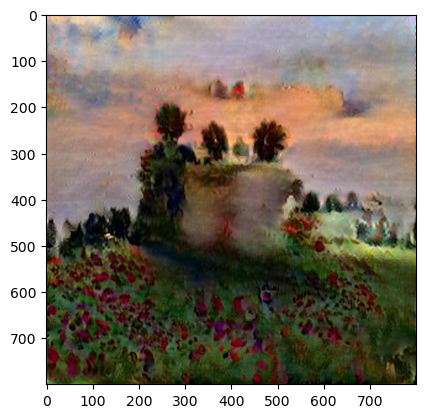

Epoch 25 with J: 1567.647705078125, J_style: 0.3913399577140808, J_content: 0.45210281014442444, J_noise: 47941.78125
Epoch 50 with J: 917.364990234375, J_style: 0.22876988351345062, J_content: 0.450577050447464, J_noise: 48316.546875
Epoch 75 with J: 703.7825927734375, J_style: 0.17537374794483185, J_content: 0.450612872838974, J_noise: 48519.5703125
Epoch 100 with J: 585.1358642578125, J_style: 0.14571137726306915, J_content: 0.4508831799030304, J_noise: 48680.6640625
Epoch 125 with J: 508.6016540527344, J_style: 0.1265772432088852, J_content: 0.45109617710113525, J_noise: 48829.66015625
Epoch 150 with J: 455.50787353515625, J_style: 0.11330325156450272, J_content: 0.45130613446235657, J_noise: 48963.34375
Epoch 175 with J: 416.5864562988281, J_style: 0.10357236862182617, J_content: 0.4515267610549927, J_noise: 49083.7265625
Epoch 200 with J: 386.5180969238281, J_style: 0.0960547924041748, J_content: 0.4517439901828766, J_noise: 49193.7734375
Epoch 225 with J: 362.46099853515625, J_s

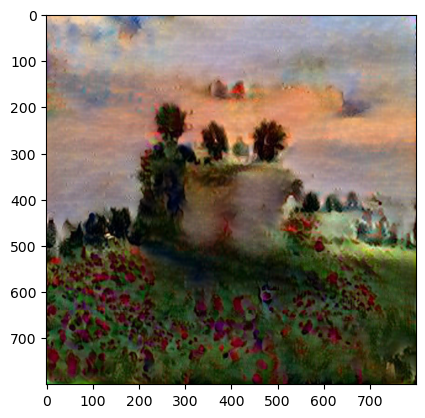

Epoch 275 with J: 325.6878662109375, J_style: 0.08084596693515778, J_content: 0.45228901505470276, J_noise: 49483.4453125
Epoch 300 with J: 311.0985412597656, J_style: 0.07719825953245163, J_content: 0.452445387840271, J_noise: 49571.4609375
Epoch 325 with J: 298.33782958984375, J_style: 0.07400771975517273, J_content: 0.4525902271270752, J_noise: 49656.78125
Epoch 350 with J: 286.9993896484375, J_style: 0.07117277383804321, J_content: 0.4527239203453064, J_noise: 49739.6640625
Epoch 375 with J: 276.8561096191406, J_style: 0.06863663345575333, J_content: 0.45284467935562134, J_noise: 49820.765625
Epoch 400 with J: 267.6552429199219, J_style: 0.06633608043193817, J_content: 0.4529736340045929, J_noise: 49901.0546875
Epoch 425 with J: 259.3265380859375, J_style: 0.06425359845161438, J_content: 0.4530838131904602, J_noise: 49979.9453125
Epoch 450 with J: 251.68458557128906, J_style: 0.0623428039252758, J_content: 0.4531992971897125, J_noise: 50057.3125
Epoch 475 with J: 244.67018127441406

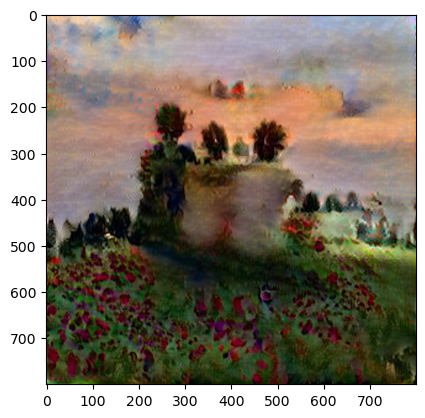

Epoch 525 with J: 232.1902618408203, J_style: 0.05746832862496376, J_content: 0.45352718234062195, J_noise: 50284.25
Epoch 550 with J: 226.576904296875, J_style: 0.056064702570438385, J_content: 0.45362743735313416, J_noise: 50358.8515625
Epoch 575 with J: 221.36021423339844, J_style: 0.05476025119423866, J_content: 0.45371824502944946, J_noise: 50432.703125
Epoch 600 with J: 216.45664978027344, J_style: 0.05353408679366112, J_content: 0.45380842685699463, J_noise: 50506.11328125
Epoch 625 with J: 211.8454132080078, J_style: 0.0523810088634491, J_content: 0.4538949131965637, J_noise: 50579.4140625
Epoch 650 with J: 207.52810668945312, J_style: 0.051301419734954834, J_content: 0.4539811909198761, J_noise: 50651.9921875
Epoch 675 with J: 203.4337921142578, J_style: 0.05027757212519646, J_content: 0.4540683925151825, J_noise: 50723.71875
Epoch 700 with J: 199.56715393066406, J_style: 0.04931065812706947, J_content: 0.45414382219314575, J_noise: 50795.734375
Epoch 725 with J: 195.896118164

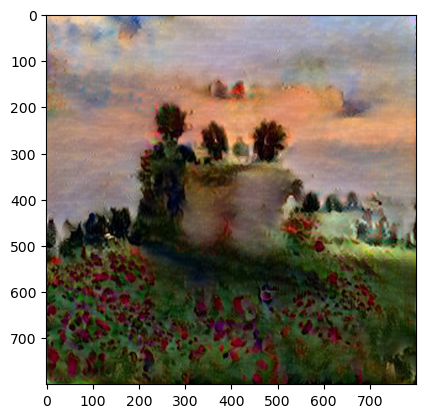

Epoch 775 with J: 189.11245727539062, J_style: 0.04669623076915741, J_content: 0.4543585479259491, J_noise: 51010.5078125
Epoch 800 with J: 185.9752197265625, J_style: 0.04591168090701103, J_content: 0.45441916584968567, J_noise: 51081.15625
Epoch 825 with J: 182.9822540283203, J_style: 0.04516319930553436, J_content: 0.4544845521450043, J_noise: 51151.91796875
Epoch 850 with J: 180.11813354492188, J_style: 0.044446926563978195, J_content: 0.4545503258705139, J_noise: 51222.19140625
Epoch 875 with J: 177.3863525390625, J_style: 0.04376376047730446, J_content: 0.4545987546443939, J_noise: 51292.2421875
Epoch 900 with J: 174.76524353027344, J_style: 0.0431082509458065, J_content: 0.4546561539173126, J_noise: 51361.859375
Epoch 925 with J: 172.25633239746094, J_style: 0.042480796575546265, J_content: 0.4547070562839508, J_noise: 51431.15625
Epoch 950 with J: 169.84153747558594, J_style: 0.04187687113881111, J_content: 0.4547586441040039, J_noise: 51500.70703125
Epoch 975 with J: 167.52949

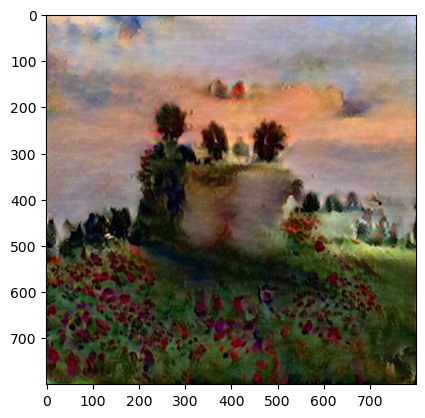

Epoch 1025 with J: 163.16029357910156, J_style: 0.040205903351306915, J_content: 0.45490169525146484, J_noise: 51708.17578125
Epoch 1050 with J: 161.0979461669922, J_style: 0.03969008848071098, J_content: 0.4549524784088135, J_noise: 51777.10546875
Epoch 1075 with J: 159.10923767089844, J_style: 0.039192698895931244, J_content: 0.45499515533447266, J_noise: 51845.62890625
Epoch 1100 with J: 157.19058227539062, J_style: 0.03871282935142517, J_content: 0.4550318121910095, J_noise: 51914.0
Epoch 1125 with J: 155.3303985595703, J_style: 0.03824758157134056, J_content: 0.4550633728504181, J_noise: 51982.36328125
Epoch 1150 with J: 153.5353546142578, J_style: 0.037798620760440826, J_content: 0.45508983731269836, J_noise: 52050.828125
Epoch 1175 with J: 151.8202362060547, J_style: 0.03736964613199234, J_content: 0.455110639333725, J_noise: 52118.80859375
Epoch 1200 with J: 150.14175415039062, J_style: 0.03694983944296837, J_content: 0.45513007044792175, J_noise: 52186.5234375
Epoch 1225 with 

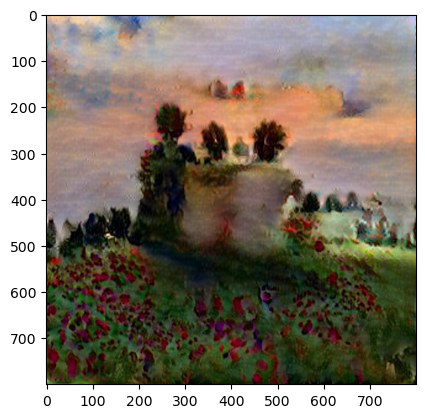

Epoch 1275 with J: 145.42514038085938, J_style: 0.03577013686299324, J_content: 0.4551742970943451, J_noise: 52389.94921875


KeyboardInterrupt: 

In [7]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2000
for i in range(epochs):
    J, J_style, J_content, J_noise = train_step(generated_image)
    if i % 25 == 0:
        print(f"Epoch {i} with J: {J}, J_style: {J_style}, J_content: {J_content}, J_noise: {J_noise}")
        #for i, layer_cost in enumerate(J_style):
        #    print(f"Layer {STYLE_LAYERS[i]} cost: {layer_cost}")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()